# INM 706 Coursework Code
# Sentiment Prediction of drug reviews dataset using BERT (Bidirectional Encoder Representation from Transformers)
## By: Elisabeta Monica Furdui: 190045971 and Jasveen Kaur: 190020638 

## Dataset Interface

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import pickle
import random
import re
import time
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, AutoModelWithLMHead

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

I0826 15:36:17.702810  3292 file_utils.py:38] PyTorch version 1.1.0 available.


### Raw Train and Test dataset

In [2]:
df_train = pd.read_csv('./drugsCom_raw/drugsComTrain_raw.tsv', delimiter='\t',encoding='utf-8')
df_test = pd.read_csv('./drugsCom_raw/drugsComTest_raw.tsv', delimiter='\t',encoding='utf-8')

In [3]:
#dataset sample
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null float64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     53766 non-null int64
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null float64
date           53766 non-null object
usefulCount    53766 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


### Converting the ratings to sentiment values and adding a new column named 'sentiment', where: Postive: 2, Neutral: 1, Negative: 0

In [6]:
def to_sentiment(rat):
    rat = int(rat)
    if rat <= 3:
        return 0
    elif rat == 4 or rat == 7:
        return 1
    else: 
        return 2

df_train['sentiment'] = df_train.rating.apply(to_sentiment)
df_test['sentiment'] = df_test.rating.apply(to_sentiment)

### Defining a function to preprocess the reviews using regex library.

In [7]:
def text_preprocessing(text):
    # Remove '@name'
    text = text.replace('"',"")
    
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove '&#039;'
    text = re.sub(r'&#039;',"'", text)
    return text

In [8]:
for i in range(len(df_train['review'])):
    text_preprocessing(df_train['review'][i])
for i in range(len(df_test['review'])):
    text_preprocessing(df_test['review'][i])

### Dataframes after removing extra columns and splitting the train data into train and validation

In [9]:
#dropping the columns that are not needed
train = df_train.drop(['Unnamed: 0','drugName','condition','date','rating','usefulCount'], axis = 1)
test = df_test.drop(['Unnamed: 0','drugName','condition','date','rating','usefulCount'], axis = 1)

In [10]:
train.head()

,review,sentiment
0,"""It has no side effect, I take it in combinati...",2
1,"""My son is halfway through his fourth week of ...",2
2,"""I used to take another oral contraceptive, wh...",2
3,"""This is my first time using any form of birth...",2
4,"""Suboxone has completely turned my life around...",2


In [11]:
train_data = train.sample(frac=0.8, random_state=1)
val_data = train[~train.index.isin(train_data.index)]
test_data = test

Negative 0: 27958
Neutral 1: 11590
Positive 2: 89490


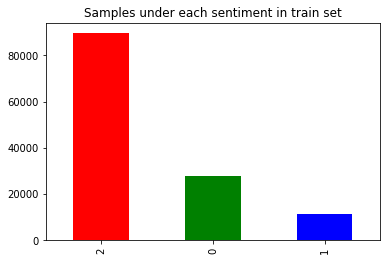

In [12]:
sentiment_count = train_data.sentiment.value_counts()
print('Negative 0:', sentiment_count[0])
print('Neutral 1:', sentiment_count[1])
print('Positive 2:', sentiment_count[2])

sentiment_count.plot(kind='bar', title='Samples under each sentiment in train set', color = list('rgb'))

Negative 0: 11838
Neutral 1: 4750
Positive 2: 37178


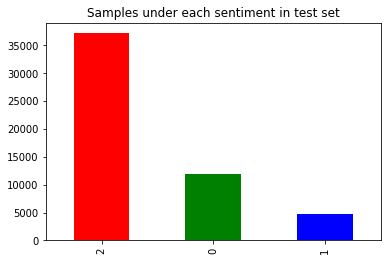

In [13]:
sentiment_count = test_data.sentiment.value_counts()
print('Negative 0:', sentiment_count[0])
print('Neutral 1:', sentiment_count[1])
print('Positive 2:', sentiment_count[2])

sentiment_count.plot(kind='bar', title='Samples under each sentiment in test set', color = list('rgb'))

Negative 0: 7105
Neutral 1: 2878
Positive 2: 22276


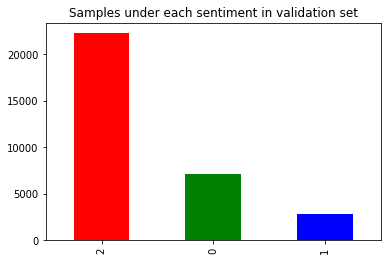

In [14]:
sentiment_count = val_data.sentiment.value_counts()
print('Negative 0:', sentiment_count[0])
print('Neutral 1:', sentiment_count[1])
print('Positive 2:', sentiment_count[2])

sentiment_count.plot(kind='bar', title='Samples under each sentiment in validation set', color = list('rgb'))

### Bert specific preprocessing: 
Using encode_plus to preprocess the reviews: Tokenize using BertTokenizer ('bert-base-cased'), add special tokens ( [CLS], [PAD], [SEP], [UNK] ), truncate the reviews to a maximum length of 512 and return the attention masks.

In [15]:
# Loading the bert tokenizers for different domain Bert models

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

I0826 15:36:30.281196  3292 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/dmis-lab/biobert-v1.1/config.json from cache at C:\Users\adbb083\.cache\torch\transformers\f8aa55d48600e63a39633cbb1bd933404d161174c7cabf1b4059b574404d6c19.08d27a67caf57f599c177c8e7fefc24d3e2f9a4e6ed2feca12f613f48c66ce07
I0826 15:36:30.281196  3292 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0826 15:36:30.296856  3292 tokenization_utils.py:925] Model name 'dmis-lab/biobert-v1.1' not found i

In [16]:
#Special tokens used by BERT

print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)


[UNK] 100
[SEP] 102
[CLS] 101
[PAD] 0


In [17]:
class Bert_specific_preprocessing(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review, #= text_preprocessing(review),
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt')

        return {'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)}

### Using Pytorch Dataloader to load the preprocessed dataset

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = Bert_specific_preprocessing(reviews=df.review.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len)

    return DataLoader(ds,
    batch_size=batch_size,
    num_workers=0)

BATCH_SIZE = 16
MAX_LEN = 512

train_data_loader = create_data_loader(train_data[:10000], tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data[:8000], tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data[:8000], tokenizer, MAX_LEN, BATCH_SIZE)


## Model and Custom Functionality

### Pretrained BERT models used: Bert Base Cased, BioClinicalBert and BioBert 

In [19]:
#bert_model = BertModel.from_pretrained('bert-base-cased')
#bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

I0826 15:36:32.374751  3292 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/dmis-lab/biobert-v1.1/config.json from cache at C:\Users\adbb083\.cache\torch\transformers\f8aa55d48600e63a39633cbb1bd933404d161174c7cabf1b4059b574404d6c19.08d27a67caf57f599c177c8e7fefc24d3e2f9a4e6ed2feca12f613f48c66ce07
I0826 15:36:32.374751  3292 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0826 15:36:32.437570  3292 modeling_utils.py:617] loading weights file https://cdn.huggingface.co/dm

### BERT with 2 Linear layers

In [20]:
class BERT_Sentiment(nn.Module):

    def __init__(self):
        super(BERT_Sentiment, self).__init__()
        
        self.bert = bert_model
        
        self.linear1 = nn.Linear(768, 512)
        self.drop = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        
        self.out = nn.Linear(512, 3)
  
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        x = self.linear1(pooled_output)
        x = self.relu(x)
        x = self.drop(x)
        output = self.out(x)
        
        return output

### BERT with 2 GRU layers and one linear layer

In [21]:
class BERTGRU_Sentiment(nn.Module):

    def __init__(self): 
        super(BERTGRU_Sentiment, self).__init__()          
        
        self.bert = bert_model
        
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          512,
                          num_layers = 1,
                          bidirectional = True,
                          batch_first = True)
        
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(512 * 2, 3)
        
        
        
    def forward(self, input_ids, attention_mask):

        with torch.no_grad():
            embedded = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        _, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        output = self.out(hidden)
        
        return output


## Training and Evaluation function definition

In [22]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        pred = model(input_ids=input_ids, attention_mask=attention_mask)
        #pred = F.softmax(pred, dim = 1)
        loss = loss_fn(pred, targets)
        pred_val = torch.argmax(pred, dim = 1).to(device)
        correct_predictions += torch.sum(pred_val == targets)

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        
        for d in data_loader:
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            pred = model(input_ids=input_ids, attention_mask=attention_mask)
            #pred = F.softmax(pred, dim = 1)
            loss = loss_fn(pred, targets)
            pred_val = torch.argmax(pred, dim = 1).to(device)
            correct_predictions += torch.sum(pred_val == targets)
            
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

### Training the model

In [23]:
EPOCHS = 6

class_names = ['negative', 'neutral', 'positive']
total_steps = len(train_data_loader) * EPOCHS

loss_fn = nn.CrossEntropyLoss().to(device)

best_accuracy = 0
t_acc = []
t_loss =[]
v_loss = []
v_acc = []

In [24]:
# BERT with 2 linear layers: model 1

model1 = BERT_Sentiment()
model1 = model1.to(device)

#optimizer1 = torch.optim.RMSprop(model1.parameters(), lr=2e-5)
optimizer1 = AdamW(model1.parameters(), lr=2e-5, correct_bias=False)
scheduler1 = get_linear_schedule_with_warmup(optimizer1, num_warmup_steps=0, num_training_steps=total_steps)

In [25]:
#BERT with GRU layer: model 2

model2 = BERTGRU_Sentiment()
model2 = model2.to(device)

#optimizer2 = torch.optim.RMSprop(model2.parameters(), lr=2e-5)
optimizer2 = AdamW(model2.parameters(), lr=2e-5, correct_bias=False)
scheduler2 = get_linear_schedule_with_warmup(optimizer2, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Training the model
start_time = time.time()
for epoch in range(EPOCHS):

    print("Epoch", epoch +1)

    train_acc, train_loss = train_model(model1, train_data_loader, loss_fn, optimizer1, device, scheduler1, len(train_data[:10000]))
    print("Train loss:", "{:.3f}".format(train_loss), "| Train accuracy", "{:.2f}".format(train_acc*100),"%")
    
    val_acc, val_loss = eval_model(model1, val_data_loader, loss_fn, device, len(val_data[:8000]))
    print("Val loss:", "{:.3f}".format(val_loss), "| Val accuracy", "{:.2f}".format(val_acc*100),"%")
    
    print("Time: {}".format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start_time))))
    print()
    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_loss.append(val_loss)
    v_acc.append(val_acc)
    
    pickle.dump(t_acc, open('./t_acc.pickle','wb'))
    pickle.dump(v_acc, open('./v_acc.pickle','wb'))
    pickle.dump(t_loss, open('./t_loss.pickle','wb'))
    pickle.dump(v_loss, open('./v_loss.pickle','wb'))

    if val_acc > best_accuracy:
        torch.save(model1.state_dict(), 'LINEAR_BioBert.pt')
        best_accuracy = val_acc


## Evaluating the performance of the trained model on test dataset

#### Loading the pretrained custom model 

In [27]:
model1 = BERT_Sentiment()
model1.load_state_dict(torch.load('./LINEAR_BioBert/LINEAR_BioBert.pt', map_location = device))
model1 = model1.to(device)

In [28]:
test_acc, test_loss = eval_model(model1, test_data_loader, loss_fn, device, len(test_data[:8000]))
print("Test loss:", "{:.3f}".format(test_loss), "| Test Accuracy", "{:.2f}".format(test_acc*100),"%")

Test loss: 0.516 | Test Accuracy 81.08 %


## Prediction on Test data and individual reviews

#### Defining a function to predict the sentiment of test dataset and individual reviews

In [29]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            pred = model(input_ids=input_ids,
            attention_mask=attention_mask)

            pred_val = torch.argmax(pred, dim = 1).to(device)
            preds = pred_val 
            probs = F.softmax(pred, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
  
    return review_texts, predictions, prediction_probs, real_values

In [30]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model1, test_data_loader)

### F1 Score

In [31]:
print("F1 Score:", "{:.3f}".format( metrics.f1_score(y_test, y_pred, labels=None, average='micro')))

F1 Score: 0.811


### Sentiment Prediction on Test Data

In [32]:
idx = 1

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
predicted_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print(review_text)
print()
print("Predicted sentiment value:", predicted_sentiment.numpy())
print("Predicted sentiment:", class_names[predicted_sentiment])
print()
print("True sentiment value:", true_sentiment.numpy())
print("True sentiment:", class_names[true_sentiment])

"My son has Crohn&#039;s disease and has done very well on the Asacol.  He has no complaints and shows no side effects.  He has taken as many as nine tablets per day at one time.  I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically."

Predicted sentiment value: 2
Predicted sentiment: positive

True sentiment value: 2
True sentiment: positive


In [33]:
idx = 29

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
predicted_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print(review_text)
print()
print("Predicted sentiment value:", predicted_sentiment.numpy())
print("Predicted sentiment:", class_names[predicted_sentiment])
print()
print("True sentiment value:", true_sentiment.numpy())
print("True sentiment:", class_names[true_sentiment])

"I am a 25 year old female. I was diagnosed with bipolar II disorder about 5 years ago. I have been taking 150mg of lamotrigine for over 2 years. Thus far I have experienced significant improvements in controlling my bipolar II disorder. I recently paired 100mg of sertraline to improve the lows. Also, I experience rapid cycling. I rated this drug 70% as I feel I still have a long way to go in recovery. But, the drug has definitely allowed me to be a highly functioning individual."

Predicted sentiment value: 2
Predicted sentiment: positive

True sentiment value: 1
True sentiment: neutral


### Sentiment prediction on Raw data

In [35]:
raw_text = 'I need to take many dosages to see the effect. It harms my nervous system and makes me feel more sick. I am not taking it again and will not recommend it to anyone.' 

encoded_review = tokenizer.encode_plus(
  raw_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

pred = model1(input_ids, attention_mask)

pred_val = torch.argmax(pred, dim = 1).to(device)
probs = F.softmax(pred, dim=1)

print("Review text:", raw_text)
print("Sentiment probabilities:", probs)
print()
print("sentiment value:", pred_val)
print("Sentiment:", class_names[pred_val])

Review text: I need to take many dosages to see the effect. It harms my nervous system and makes me feel more sick. I am not taking it again and will not recommend it to anyone.
Sentiment probabilities: tensor([[0.8954, 0.0632, 0.0414]], device='cuda:0', grad_fn=<SoftmaxBackward>)

sentiment value: tensor([0], device='cuda:0')
Sentiment: negative
